# Preprocessing and images upload

In [1]:
import numpy as np
import subprocess
import random
import progressbar
from glob import glob
from skimage import io

In [2]:
np.random.seed(5) # for reproducibility
progress = progressbar.ProgressBar(widgets=[progressbar.Bar('*', '[', ']'), progressbar.Percentage(), ' '])

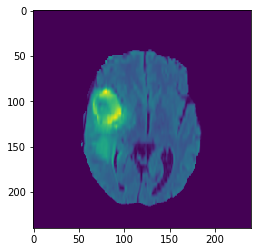

In [6]:
import matplotlib.pyplot as plt

img=io.imread("/Users/barrm/Documents/NYU/Image & Video Processing/project/BRATS_2015/Training/HGG/brats_2013_pat0001_1/VSD.Brain.XX.O.MR_Flair.54512/VSD.Brain.XX.O.MR_Flair.54512.mha", plugin='simpleitk').astype(float)

plt.imshow(img[70,:,:])
plt.show()

In [66]:
class BrainPipeline(object):
    '''
    A class for processing brain scans for one patient
    INPUT:  (1) filepath 'path': path to directory of one patient. Contains following mha files:
            flair, t1, t1c, t2, ground truth (gt)
            (2) bool 'n4itk': True to use n4itk normed t1 scans (defaults to True)
            (3) bool 'n4itk_apply': True to apply and save n4itk filter to t1 and t1c scans for given patient. This will only work if the
    '''
    def __init__(self, path, n4itk = True, n4itk_apply = False):
        self.path = path
        self.n4itk = n4itk
        self.n4itk_apply = n4itk_apply
        self.modes = ['flair', 't1', 't1c', 't2', 'gt']
        # slices=[[flair x 155], [t1], [t1c], [t2], [gt]], 155 per modality
        self.slices_by_mode, n = self.read_scans()
        # [ [slice1 x 5], [slice2 x 5], ..., [slice155 x 5]]
        self.slices_by_slice = n
        self.normed_slices = self.norm_slices()

    def read_scans(self):
        '''
        goes into each modality in patient directory and loads individual scans.
        transforms scans of same slice into strip of 5 images
        '''
        print ('Loading scans...')
        slices_by_mode = np.zeros((5, 155, 240, 240))
        slices_by_slice = np.zeros((155, 5, 240, 240))
        flair = glob(self.path + '/*Flair*/*.mha')
        t2 = glob(self.path + '/*_T2*/*.mha')
        gt = glob(self.path + '/*more*/*.mha')
        t1s = glob(self.path + '/*T1*/*.mha')
        t1_n4 = glob(self.path + '/*T1c*/*.mha')  # <-----  CAHNGE TO t1c
        t1 = [scan for scan in t1s if scan not in t1_n4]

        #scans = [flair[0], t1[0], t1[1], t2[0], gt[0]] # directories to each image (5 total)
        #if self.n4itk_apply:
        #    print ('-> Applyling bias correction...')
        #    for t1_path in t1:
        #        self.n4itk_norm(t1_path) # normalize files
        #    scans = [flair[0], t1_n4[0], t1_n4[1], t2[0], gt[0]]
        #elif self.n4itk:
        scans = [flair[0], t1_n4[0], t1_n4[0], t2[0], gt[0]]
        for scan_idx in range(5):
            # read each image directory, save to self.slices
            slices_by_mode[scan_idx] = io.imread(scans[scan_idx], plugin='simpleitk').astype(float)
        for mode_ix in range(slices_by_mode.shape[0]): # modes 1 thru 5
            for slice_ix in range(slices_by_mode.shape[1]): # slices 1 thru 155
                slices_by_slice[slice_ix][mode_ix] = slices_by_mode[mode_ix][slice_ix] # reshape by slice
        return slices_by_mode, slices_by_slice
    
    def norm_slices(self):
        '''
        normalizes each slice in self.slices_by_slice, excluding gt
        subtracts mean and div by std dev for each slice
        clips top and bottom one percent of pixel intensities
        if n4itk == True, will apply n4itk bias correction to T1 and T1c images
            '''

        print('Normalizing slices...')
        normed_slices = np.zeros((155, 5, 240, 240))
        for slice_ix in range(155):
            normed_slices[slice_ix][-1] = self.slices_by_slice[slice_ix][-1]
            for mode_ix in range(4):
                normed_slices[slice_ix][mode_ix] =  self._normalize(self.slices_by_slice[slice_ix][mode_ix])
        print('Done')
        return normed_slices

    def _normalize(self, slice):
        '''
        INPUT:  (1) a single slice of any given modality (excluding gt)
                (2) index of modality assoc with slice (0=flair, 1=t1, 2=t1c, 3=t2)
        OUTPUT: normalized slice
         '''
        b, t = np.percentile(slice, (0.5,99.5))
        slice = np.clip(slice, b, t)
        if np.std(slice) == 0:
            return slice
        else:
            return (slice - np.mean(slice)) / np.std(slice)
        
    def save_patient(self, reg_norm_n4, patient_num):
        '''
        INPUT:  (1) int 'patient_num': unique identifier for each patient
                (2) string 'reg_norm_n4': 'reg' for original images, 'norm' normalized images, 'n4' for n4 normalized images
        OUTPUT: saves png in Norm_PNG directory for normed, Training_PNG for reg
        '''
        print ('Saving scans for patient {}...'.format(patient_num))
        progress.currval = 0
        if reg_norm_n4 == 'norm': #saved normed slices
            for slice_ix in range(155): # reshape to strip
                strip = self.normed_slices[slice_ix].reshape(1200, 240)
                if np.max(strip) != 0: # set values < 1
                    strip /= np.max(strip)
                if np.min(strip) <= -1: # set values > -1
                    strip /= abs(np.min(strip))
                # save as patient_slice.png
                io.imsave('Norm_PNG/{}_{}.png'.format(patient_num, slice_ix), strip)
        elif reg_norm_n4 == 'reg':
            for slice_ix in range(155):
                strip = self.slices_by_slice[slice_ix].reshape(1200, 240)
                if np.max(strip) != 0:
                    strip /= np.max(strip)
                io.imsave('Training_PNG/{}_{}.png'.format(patient_num, slice_ix), strip)
        else:
            for slice_ix in range(155): # reshape to strip
                strip = self.normed_slices[slice_ix].reshape(1200, 240)
                if np.max(strip) != 0: # set values < 1
                    strip /= np.max(strip)
                if np.min(strip) <= -1: # set values > -1
                    strip /= abs(np.min(strip))
                # save as patient_slice.png
                io.imsave('n4_PNG/{}_{}.png'.format(patient_num, slice_ix), strip)
    
    

In [67]:
#bias correc?

In [68]:
def save_patient_slices(patients, type):
    '''
    INPUT   (1) list 'patients': paths to any directories of patients to save. for example- glob("Training/HGG/**")
            (2) string 'type': options = reg (non-normalized), norm (normalized, but no bias correction), n4 (bias corrected and normalized)
    saves strips of patient slices to approriate directory (Training_PNG/, Norm_PNG/ or n4_PNG/) as patient-num_slice-num
    '''
    for patient_num, path in enumerate(patients):
        a = BrainPipeline(path)
        a.save_patient(type, patient_num)

In [69]:
def save_labels(fns):
    '''
    INPUT list 'fns': filepaths to all labels
    '''
    progress.currval = 0
    for label_idx in range(len(labels)):
        slices = io.imread(labels[label_idx], plugin = 'simpleitk')
        for slice_idx in range(len(slices)):
            io.imsave('Labels/{}_{}L.png'.format(label_idx, slice_idx), slices[slice_idx])

In [71]:
if __name__ == '__main__':
    #labels = glob('BRATS_2015/Training/HGG/**/*more*/*.mha')
    #save_labels(labels)
    patients = glob('BRATS_2015/Training/HGG/**')
    #save_patient_slices(patients, 'reg')
    save_patient_slices(patients, 'norm')
    #save_patient_slices(patients, 'n4')

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/0_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/0_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/0_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/0_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppres

Done
Saving scans for patient 0...


Lossy conversion from float64 to uint8. Range [-0.03716698231518111, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04134182599313102, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.045969901545207255, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04842648164171212, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.049851260944870836, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05183893134184393, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.054640929574899404, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion 

Lossy conversion from float64 to uint8. Range [-0.1327579809912487, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.13321606163377864, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1333405312472722, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.13409323623586605, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1349348853652406, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.13825014123382673, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.13985838982612597, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from f

Lossy conversion from float64 to uint8. Range [-0.045611356542578946, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04150525838348315, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03753173797076911, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03364099718557591, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03013525756649208, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.026068990487603923, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.019560274389643324, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion 

Loading scans...
Normalizing slices...


Lossy conversion from float64 to uint8. Range [-0.013033805291737153, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.015283101038348334, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.019742603829163593, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.024490863083676404, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.02832035754724869, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.033458586490972456, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.038571770825679565, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversi

Done
Saving scans for patient 1...


Lossy conversion from float64 to uint8. Range [-0.060060401376391515, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06310949963875688, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06549786659835079, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06721448414903945, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06724048269387164, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06540254430639209, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06340935716452586, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fr

Lossy conversion from float64 to uint8. Range [-0.17345983624497494, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.17373013380863966, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1777529554282322, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.18354492192974303, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.18602352011717613, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1840921915613441, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1778082359451559, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from f

Lossy conversion from float64 to uint8. Range [-0.026968009440022644, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.018895466721797764, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.01394377473388547, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/1_133.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.0092840338249999, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/1_134.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.006264040857970245, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anacond

Loading scans...
Normalizing slices...


Lossy conversion from float64 to uint8. Range [-0.032136279135495834, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03397988340194983, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.035836973650459805, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03852531614794818, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04020733442938276, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04246241376763697, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04338253427504083, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion f

Done
Saving scans for patient 2...


Lossy conversion from float64 to uint8. Range [-0.049182356518884175, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05054799321706505, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.051651088292292154, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05265050841773172, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05388468905820489, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05590998095693419, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05670688758136181, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion f

Lossy conversion from float64 to uint8. Range [-0.15567134153370213, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15611181099464133, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15701352568549404, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15762036735712445, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15812488291266127, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15839808395785906, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1584537557876982, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from

Lossy conversion from float64 to uint8. Range [-0.020460399338471862, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.013324952607216311, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/2_132.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.008222908394940682, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/2_133.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/2_134.png is a low contrast image
Lossy conversion from float64 to uint8. Range [

Loading scans...
Normalizing slices...


Lossy conversion from float64 to uint8. Range [-0.035069317915304925, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03618899838297324, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.038801008085507606, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04401395785287402, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04798229905086905, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05378174961194645, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05654137712447539, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion f

Done
Saving scans for patient 3...


Lossy conversion from float64 to uint8. Range [-0.06671788087927322, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06845938264863378, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.07018903489243558, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.07054817420224645, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0684445300844961, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06800755535240956, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.07034889809634225, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from

Lossy conversion from float64 to uint8. Range [-0.16906597569320914, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16910750096697036, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1690066259003118, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.168983316809458, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1690456625892784, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16905109125933312, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1690076840840356, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from flo

Lossy conversion from float64 to uint8. Range [-0.051728192932463876, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04625255193712009, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03993178121149393, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03203158035963659, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.025536696032199956, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.018473223024987703, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.011845251464257075, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/4_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/4_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/4_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/4_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.005331482135093314, 1.0]. Convert image to uint8 prio

Done
Saving scans for patient 4...


Lossy conversion from float64 to uint8. Range [-0.05136519286536251, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05510014895270172, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.058191408735639466, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06066779417279902, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06040982619803442, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06027230078766781, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06095323620226898, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fr

Lossy conversion from float64 to uint8. Range [-0.17824863923529735, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.17858022495400724, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.17901360689437915, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.18086226313852594, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.18254954353243313, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.18331598139759697, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1870979341852046, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from

Lossy conversion from float64 to uint8. Range [-0.01721319205873324, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.013348524726725425, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/4_133.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.00819008937592911, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/4_134.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/4_135.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0,

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/5_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/5_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/5_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/5_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppres

Done
Saving scans for patient 5...


Lossy conversion from float64 to uint8. Range [-0.03761799095851862, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04253840897669071, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04626968215381438, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.048948994403772005, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05265915850503766, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05408509631777384, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.056426153212777136, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion f

Lossy conversion from float64 to uint8. Range [-0.16575114548537914, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16483006402267034, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16262270844280233, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15812125043900602, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15500125034204892, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15175659140047926, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15015384401584397, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fro

Lossy conversion from float64 to uint8. Range [-0.035474059164073986, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.02943203338298612, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.022265483112556404, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.01682418327186084, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0166079400414591, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.013694787913440209, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/5_140.png is a low contrast image
Lossy conversion from

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/6_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/6_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/6_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/6_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppres

Done
Saving scans for patient 6...


Lossy conversion from float64 to uint8. Range [-0.033739809856964495, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03727809309609368, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03968748968666095, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.042183074088730024, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04409775782626026, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04644640892047026, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.048208133447371064, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion 

Lossy conversion from float64 to uint8. Range [-0.14692586259796497, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14652315465079485, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14622908162259757, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1461372047560082, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14586781890819966, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14579589641329854, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14580662163636404, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from

/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/6_134.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/6_135.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/6_136.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/6_137.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/7_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/7_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/7_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/7_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppres

Done
Saving scans for patient 7...


Lossy conversion from float64 to uint8. Range [-0.04448538109651605, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04718189911779042, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05098550699319984, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.053132386724924825, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05598217262191876, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05744609948052417, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.059815076745582764, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion f

Lossy conversion from float64 to uint8. Range [-0.15745431742113475, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15735337327643611, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15725774128254527, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15722653161517133, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1572026024483134, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15732877758628933, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1572555302662024, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from 

Lossy conversion from float64 to uint8. Range [-0.03028757210116288, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0230634333678216, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.016746627689915868, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.010910159265541612, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/7_137.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.005891422357840717, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/7_138.png is a low contrast image
Lossy conversion from fl

Loading scans...
Normalizing slices...


Lossy conversion from float64 to uint8. Range [-0.01948570314031702, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.02294568437214397, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.02683319037060119, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.032310185128301055, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03646306100686859, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04006619629525831, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04240079964166809, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fr

Done
Saving scans for patient 8...


Lossy conversion from float64 to uint8. Range [-0.060323611700010576, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.062134001516318156, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0628812993149507, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06290716855454537, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.062482571075107504, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06327841135847535, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06389096994670952, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion f

Lossy conversion from float64 to uint8. Range [-0.1365875374329991, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.13670424907845874, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.13736062061457366, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.13754278723701696, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.13883639694173452, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.13932511089004507, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1406842439198942, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from 

Lossy conversion from float64 to uint8. Range [-0.03793449468976709, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.034037927759309236, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.030588660337299272, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.026086730294797526, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.021331353158914594, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.014337023683566857, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/8_136.png is a low contrast image
Lossy conversion f

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/9_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/9_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/9_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/9_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppres

Done
Saving scans for patient 9...


Lossy conversion from float64 to uint8. Range [-0.02180848588397618, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.025834995733917458, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.02814880178639751, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03324877524119022, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.037452909558930346, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04110848916517742, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04212629658133368, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion f

Lossy conversion from float64 to uint8. Range [-0.1715476005225384, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.17193875833982092, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1721145758203914, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1722048553938022, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.17211370034393156, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1719209054700003, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.17165637194957453, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from fl

Lossy conversion from float64 to uint8. Range [-0.024293418593615695, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.013721395668471416, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/9_134.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.007843163573795529, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/9_135.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/9_136.png is a low contrast image
Lossy conversion from float64 to uint8. Range [

Loading scans...
Normalizing slices...


Lossy conversion from float64 to uint8. Range [-0.028788356217499863, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03083246179026583, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03229368992402724, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03515312694077257, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0366029315118014, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04049835415588479, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04246803868589658, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fro

Done
Saving scans for patient 10...


Lossy conversion from float64 to uint8. Range [-0.054621875864719414, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05794076653143398, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0586037494556671, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0570844820559589, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05617136224520888, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.056543579401447226, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05512834555835828, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fro

Lossy conversion from float64 to uint8. Range [-0.1500559845723014, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15153540773638424, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15170919759312368, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15633438474095204, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15887324607328251, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16017060906103783, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1609852875517239, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from 

Lossy conversion from float64 to uint8. Range [-0.018920259569585735, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.015606631816770584, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.01187618488589346, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/10_133.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.007122729355020882, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/10_134.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/s

Loading scans...
Normalizing slices...


Lossy conversion from float64 to uint8. Range [-0.020657229446787013, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0234587428717478, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.026142704691535394, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.030660924097261868, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.034803319954238764, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03978165070692681, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0425372706684275, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion f

Done
Saving scans for patient 11...


Lossy conversion from float64 to uint8. Range [-0.05904250266960844, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06192784215536678, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06328737466477505, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06457601906982413, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06537368086905769, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06764146228259954, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06954565959367477, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fro

Lossy conversion from float64 to uint8. Range [-0.15104460670019776, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1517828671297238, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15258375243872885, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14776459398836586, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14609546588688713, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14360494974540736, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14369620784126613, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from

Lossy conversion from float64 to uint8. Range [-0.036113725747968256, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.02518710289944653, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.022021929569683796, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.014047909764225172, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/11_134.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.011007603290320378, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/11_135.png is a low contrast image
Lossy conversion fro

Loading scans...
Normalizing slices...


Lossy conversion from float64 to uint8. Range [-0.044945557311773084, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0464649609571718, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04731285078036516, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.046956526166454134, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.048770054091804606, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05143407702207818, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.055132453598646707, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion 

Done
Saving scans for patient 12...


Lossy conversion from float64 to uint8. Range [-0.06916538879650028, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.07124835182651339, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.07237765406589282, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.07291471050889732, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0737643745181696, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.07406612284412877, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.07398864658558237, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from

Lossy conversion from float64 to uint8. Range [-0.16461704065096236, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16498361747056756, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.22030079712741887, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.2270937702881712, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.2241453320375548, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.22147647239320856, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.21764683579344402, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from 

Lossy conversion from float64 to uint8. Range [-0.021195713390685843, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.014778115369836845, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.01191883477890363, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/12_133.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.005415415949600243, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/12_134.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/s

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/13_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/13_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/13_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/13_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to sup

Done
Saving scans for patient 13...


Lossy conversion from float64 to uint8. Range [-0.03722803428178833, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03958901402112419, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04136383739758248, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04259835894860937, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04362675639769248, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.045357607398738606, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.048580654586689954, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion f

Lossy conversion from float64 to uint8. Range [-0.16141628345336206, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1628496829988399, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1642978866742368, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16462856355333802, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.165268338394079, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15005662223083246, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1501843075394842, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from flo

Lossy conversion from float64 to uint8. Range [-0.03549637502774999, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.030005875065945996, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0237735742305531, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.018938138038222946, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.013986033642378343, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/13_138.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.009541015636608117, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/an

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/14_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/14_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/14_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/14_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to sup

Done
Saving scans for patient 14...


Lossy conversion from float64 to uint8. Range [-0.03730150960503949, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.040428967657694784, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04344118292561495, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.046568030803584536, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04891330127921191, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.051313369916283366, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.052623903375952935, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion

Lossy conversion from float64 to uint8. Range [-0.17401508165263138, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.13648023001539725, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.13784788919397575, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.138161280311881, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.13936692843545986, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.13956412771064924, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14077176439021244, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from 

Lossy conversion from float64 to uint8. Range [-0.05143914945632832, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.045663526665956036, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04024972048666891, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.033758938912834824, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.028038155265316007, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.021310035922350198, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.014483498592590606, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/op

Loading scans...
Normalizing slices...


Lossy conversion from float64 to uint8. Range [-0.04577848427672845, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04588738926559165, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0455099455812852, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04516633797627255, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04517323604917676, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.047637678072928076, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04855718673174141, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fro

Done
Saving scans for patient 15...


Lossy conversion from float64 to uint8. Range [-0.06456647941530873, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06386307541957507, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06355292109779412, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06435316288497962, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06746853608014719, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06946926141005098, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.07211229255271218, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fro

Lossy conversion from float64 to uint8. Range [-0.16754630768796802, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16724073243471083, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1668929970286504, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16634676803998613, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16578504721366794, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16515800688750726, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1644938373915359, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from 

Lossy conversion from float64 to uint8. Range [-0.0346387847425942, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0292151219103994, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.02089272990786353, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.015701436525512907, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/15_135.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.008929582541511756, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/15_136.png is a low contrast image
Lossy conversion from fl

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/16_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/16_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/16_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/16_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to sup

Done
Saving scans for patient 16...


Lossy conversion from float64 to uint8. Range [-0.042273973609359375, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.044691468031789125, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04569453261738579, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0476440922303639, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04918204898845484, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.052454528720111186, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05514535855623864, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion f

Lossy conversion from float64 to uint8. Range [-0.15856033158512126, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15856615876947902, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.158806958373229, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15892486876101244, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1589851516255443, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15913407596169665, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15898245622374643, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from f

/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/16_132.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.006858886533978826, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/16_133.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/16_134.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/16_135.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image t

Loading scans...
Normalizing slices...


Lossy conversion from float64 to uint8. Range [-0.022178706906385053, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.02552218315001808, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0263941007683853, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.028884838641348907, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.028679950296034245, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.030515773210632965, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.030113231670559574, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion

Done
Saving scans for patient 17...


Lossy conversion from float64 to uint8. Range [-0.04109573115980088, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04373502365044886, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04635040394961864, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0467954110805703, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04737092787540573, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.048357105957547976, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.049822523492664764, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fr

Lossy conversion from float64 to uint8. Range [-0.15153330426186312, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15190537255651101, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15275280449166254, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15354136783110214, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15413372878492845, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15426919966098987, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15441081903634354, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fro

Lossy conversion from float64 to uint8. Range [-0.022457120498822404, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.011145590142697786, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/17_132.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.006961954957630391, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/17_133.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/17_134.png is a low contrast image
Lossy conversion from float64 to uint8. Rang

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/18_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/18_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/18_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/18_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.008507298086368853, 1.0]. Convert image to uint8 

Done
Saving scans for patient 18...


Lossy conversion from float64 to uint8. Range [-0.044612326895800074, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.045499820339928596, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04689765740778117, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04811511070425295, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04982847263543554, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05087052013648475, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05309036765887303, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion f

Lossy conversion from float64 to uint8. Range [-0.159054531009701, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1597382334943457, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16014069411464243, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16070665842321258, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16101345420597798, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16156647947948088, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16188974505360726, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from f

Lossy conversion from float64 to uint8. Range [-0.07294991387760404, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06842310243453543, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06267516196933515, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05666636582330831, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04929023762037269, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04409344451118063, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03891811217356275, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fro

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/19_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/19_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.005387569472389257, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/19_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.00823398307127219, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.011519131561094827, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0

Done
Saving scans for patient 19...


Lossy conversion from float64 to uint8. Range [-0.05243612875005132, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.054235381661281924, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05476685779960649, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05676840202964752, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05874035631469977, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05893864412540555, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05868724823176177, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fr

Lossy conversion from float64 to uint8. Range [-0.15618521382109596, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15577355204186102, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1527418425292952, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.148502224123875, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14747668804019962, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14825190513048486, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14895726209413043, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from f

Lossy conversion from float64 to uint8. Range [-0.045522063367870465, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.042510116093714696, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03865180392859879, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.033223580496011935, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.027486542823327558, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.02210395197832097, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.017599082158056577, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversio

Loading scans...
Normalizing slices...


Lossy conversion from float64 to uint8. Range [-0.0417597411156916, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.043973569648367294, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.046600379434100205, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.047307238555966157, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04700348347427781, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04957750466417965, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05276006074685378, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion f

Done
Saving scans for patient 20...


Lossy conversion from float64 to uint8. Range [-0.059115630589369375, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05939497238250352, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.058934635950978476, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06115756136599309, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06282472645657135, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06347873591147447, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06550525867190263, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion f

Lossy conversion from float64 to uint8. Range [-0.1581432959731346, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15778907676485884, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15730333916640796, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15671082838249678, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1565538471845696, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15634756677042339, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1560832143196396, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from f

/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/20_131.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/20_132.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/20_133.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/20_134.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to savin

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/21_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/21_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/21_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/21_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to sup

Done
Saving scans for patient 21...


Lossy conversion from float64 to uint8. Range [-0.04255393583052536, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04312309384762473, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04524482247382755, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04690809230539785, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04898164244290515, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.049050247083250106, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04977355545951068, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fr

Lossy conversion from float64 to uint8. Range [-0.16148257928020232, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1640954405112772, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16598167978461173, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16822063802782627, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.17116371858577883, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.17406602686972714, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.17648566767037996, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from

Lossy conversion from float64 to uint8. Range [-0.028576502339791053, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.02035474362976252, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/21_135.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.00820903766186878, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/21_136.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/21_137.png is a low contrast image
Lossy conversion from float64 to uint8. Range 

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/22_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/22_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/22_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/22_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.00539899924922204, 1.0]. Convert image to uint8 p

Done
Saving scans for patient 22...


Lossy conversion from float64 to uint8. Range [-0.0558887849826359, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.058585870658161024, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06075621476588419, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06212667921017817, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0632889526245516, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06405265183382296, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06390592184687895, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from

Lossy conversion from float64 to uint8. Range [-0.21859472194198667, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.21847086563819595, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.21844865153158322, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.2179458914520298, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.23042028643905726, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.21658303092902786, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.215554912138994, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from f

Lossy conversion from float64 to uint8. Range [-0.014065576769144226, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/22_133.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.008429604775647085, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/22_134.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/22_135.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_l

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/23_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/23_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/23_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/23_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to sup

Done
Saving scans for patient 23...


Lossy conversion from float64 to uint8. Range [-0.04132117205342866, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.044856206314543096, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.047306650411735186, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.049496342827221235, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.050234110435846496, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05131947364112734, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05073369742730802, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion

Lossy conversion from float64 to uint8. Range [-0.15494708917878905, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15413016028365006, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15185807043631158, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15148665124107252, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15447427307882391, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1523366791398566, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15303649084120105, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from

/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/23_134.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/23_135.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/23_136.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/23_137.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to savin

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/24_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/24_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/24_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/24_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.007833147851701179, 1.0]. Convert image to uint8 

Done
Saving scans for patient 24...


Lossy conversion from float64 to uint8. Range [-0.05444980023726018, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.056880366889836075, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05936731329599859, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0644702721059122, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06465945604415457, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06399189021972859, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06425274723792578, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fro

Lossy conversion from float64 to uint8. Range [-0.17023820411957005, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16848809031130713, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16857497193125578, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1671803325754432, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16712785386072573, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1683840990406141, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1694324714154395, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from f

Lossy conversion from float64 to uint8. Range [-0.022642919303038276, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.017453261867839024, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.012072979222924891, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/24_135.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.007048196994633151, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/24_136.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/25_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/25_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.005788788869124354, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.010977730432175066, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.014196300721326743, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.017967456949619813, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range

Done
Saving scans for patient 25...


Lossy conversion from float64 to uint8. Range [-0.04488817477046126, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04737155574743775, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.050742764123139716, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05357980588342071, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05558406750299244, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.056736815226539165, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.056654140965360957, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion 

Lossy conversion from float64 to uint8. Range [-0.1517735035482461, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15140178041566424, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15101682479452685, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1508245854131035, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15063451501584965, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15067516158713612, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15063148779156538, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from 

Lossy conversion from float64 to uint8. Range [-0.046083432194762346, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03986899705294502, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.030075798107869544, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.020634471921679495, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/25_135.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.01114055147276103, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/25_136.png is a low contrast image
Lossy conversion from

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/26_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/26_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/26_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/26_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.005213178423716144, 1.0]. Convert image to uint8 

Done
Saving scans for patient 26...


Lossy conversion from float64 to uint8. Range [-0.04874114180366274, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.051630008741086905, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05340971867267498, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05322780650431184, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05200154051314547, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05385115586442069, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05468433789103539, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fr

Lossy conversion from float64 to uint8. Range [-0.13227301752447915, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.13204191297039414, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.13072711337455142, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.12654969409581504, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.12259849974520279, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.11366934401727068, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1080807852592945, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from

Lossy conversion from float64 to uint8. Range [-0.03893138072186755, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.034266344586990335, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.027237783960071066, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.020222892402803755, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.013119939116615352, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/26_137.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.00798819717911692, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/a

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/27_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.01008726819510365, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0104927622313482, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.011435815035150626, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.01371020236472984, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.015246970376606061, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.01777844234402552, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from f

Done
Saving scans for patient 27...


Lossy conversion from float64 to uint8. Range [-0.02902035068028524, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03391262370975398, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03506717775875418, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03429760353742706, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03442322343502863, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.037220226668119076, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.040168249964961426, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion f

Lossy conversion from float64 to uint8. Range [-0.16443259817685923, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16587679762742705, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16678843678416144, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16331678070026212, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1607375856413615, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15961846966882212, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16603491642134724, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from

Lossy conversion from float64 to uint8. Range [-0.03174171001973035, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.023623407584892637, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.021837298330181335, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.013996353804985784, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.010857603542905683, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/27_135.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/28_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/28_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/28_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/28_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to sup

Done
Saving scans for patient 28...


Lossy conversion from float64 to uint8. Range [-0.06421887436282528, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.067975928552727, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.07057418270652181, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.07100137798155652, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.07404185236179282, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.07832388369610635, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.08390855715461923, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from 

Lossy conversion from float64 to uint8. Range [-0.16601811401641356, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.165613941179804, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1651593794122303, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16463129106415775, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16392866890162985, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16331513756605903, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1624120075430259, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from fl

Lossy conversion from float64 to uint8. Range [-0.01638829643022162, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/28_135.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.008825141901070097, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/28_136.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.005548522683508032, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/28_137.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site

Loading scans...
Normalizing slices...


Lossy conversion from float64 to uint8. Range [-0.012441284042262106, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.016544735277505752, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.020350324948729365, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.02541182504890297, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.02803888170037814, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.031779595697605335, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.035215243144537715, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversio

Done
Saving scans for patient 29...


Lossy conversion from float64 to uint8. Range [-0.051481594859423316, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05452860305854488, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05655606704093917, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05767662708352917, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05802408501198903, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05840576326901064, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05932474914851904, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fr

Lossy conversion from float64 to uint8. Range [-0.13815575919659537, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.13846753563241693, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.13938518210606132, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.13976588268429715, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1404463920759981, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14086586294702952, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14182511555194643, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from

Lossy conversion from float64 to uint8. Range [-0.044323910583129206, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03617485851811035, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.031270647458018844, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.01945817217744663, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.013997318193414857, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/29_135.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.005193282469774174, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/a

Loading scans...
Normalizing slices...


Lossy conversion from float64 to uint8. Range [-0.021730374383421926, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.024358208879068807, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.027253252825070094, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03162504798473689, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0355694915673035, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04047245327233385, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04226574206133015, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion f

Done
Saving scans for patient 30...


Lossy conversion from float64 to uint8. Range [-0.05159756714271433, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05220500509722473, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05396954320049282, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.055217782748161415, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05698010309834531, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05777425534957571, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.056972353694947325, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion f

Lossy conversion from float64 to uint8. Range [-0.16371664229820435, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16429683087958702, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16475623669950656, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16577303395706305, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1660737076975868, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16735193268786924, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16832295992523083, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from

Lossy conversion from float64 to uint8. Range [-0.02127248163297742, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.018974453242479084, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.012707386112935199, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/30_134.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.010382244200440894, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/30_135.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.005323195965665573, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/ana

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/31_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/31_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/31_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/31_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to sup

Done
Saving scans for patient 31...


Lossy conversion from float64 to uint8. Range [-0.035949068696284225, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.040103530050009314, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04282764122681823, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04584708724364362, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04888716262337456, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05269832808854593, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05536849038989757, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion f

Lossy conversion from float64 to uint8. Range [-0.16038261419913763, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1600932530018152, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15977714120787154, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15950477434603139, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15901958124276194, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15856272764836613, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15797323278770142, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from

Lossy conversion from float64 to uint8. Range [-0.017822900755524933, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.013038259089235787, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/31_138.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.008286361178398628, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/31_139.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/31_140.png is a low contrast image
Lossy conversion from float64 to uint8. Rang

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/32_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/32_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/32_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/32_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to sup

Done
Saving scans for patient 32...


Lossy conversion from float64 to uint8. Range [-0.04189975014464022, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04280412601480268, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04455959485297828, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04500284046706236, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0482709415165832, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.051641357170239606, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.054914945462682184, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fr

Lossy conversion from float64 to uint8. Range [-0.16208117966592467, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16207062757671362, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16191938145966528, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16169143112071557, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16136660659809576, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16080873121422173, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16040504215255716, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fro

Lossy conversion from float64 to uint8. Range [-0.0352512883968688, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.026099201671820817, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.018239790448964708, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/32_136.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.010685387386583199, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/32_137.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/si

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/33_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/33_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/33_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/33_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to sup

Done
Saving scans for patient 33...


Lossy conversion from float64 to uint8. Range [-0.0476698189926042, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04949362239277394, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05214837735101059, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05307405585467151, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05409392641995164, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.054851457564829655, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.056315847046672265, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fr

Lossy conversion from float64 to uint8. Range [-0.153691620270344, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15531288159346024, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.156534493820351, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1587572852866536, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16062880111036898, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.163825866704862, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16563432784865334, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float

Lossy conversion from float64 to uint8. Range [-0.028133042335977354, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0194706377630706, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/33_135.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.0077009577449601435, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/33_136.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/33_137.png is a low contrast image
Lossy conversion from float64 to uint8. Range

Loading scans...
Normalizing slices...


Lossy conversion from float64 to uint8. Range [-0.04404431467978756, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.049232549761807874, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05169099598192927, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.052379885605474366, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.052363855054756034, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.053412568345088784, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.054414378973009395, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversio

Done
Saving scans for patient 34...


Lossy conversion from float64 to uint8. Range [-0.05887091013875621, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06065972328864366, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06322687017982648, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0683759593294571, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.07075966235903644, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.07190077110570145, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06994068696875254, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from

Lossy conversion from float64 to uint8. Range [-0.16078317059483124, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16071949510435046, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1647553449856477, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16593145385068858, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.167261031356091, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16822906853750488, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16881417226291495, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from f

Lossy conversion from float64 to uint8. Range [-0.030272579033337594, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.024888121770842285, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.020880440128556044, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.014903693383192475, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.011415655043958584, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/34_135.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.007520882288549995, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt

Loading scans...
Normalizing slices...


Lossy conversion from float64 to uint8. Range [-0.043796253625800266, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.046017270049523495, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04568397467721804, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04752886981049769, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.049205061336764215, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05227343587964999, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05465710825402307, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion 

Done
Saving scans for patient 35...


Lossy conversion from float64 to uint8. Range [-0.06550175443275742, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06730133168563418, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06909749604668619, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.07253578017452687, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.07456378070509667, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.07656309240616184, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.07625405495616605, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fro

Lossy conversion from float64 to uint8. Range [-0.26770128069422894, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.26836623277043603, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.2711062215313109, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.2704281534197658, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.26781770760636653, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.2632786714209353, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.25614866421287497, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from f

Lossy conversion from float64 to uint8. Range [-0.025079256969994808, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.017605839305490176, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.014110555832247832, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/35_133.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.006615025026480999, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/35_134.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/36_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.006096207190963043, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/36_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.010949493303683543, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.01358497162319935, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.017141686505632314, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.01888251476748794, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from flo

Done
Saving scans for patient 36...


Lossy conversion from float64 to uint8. Range [-0.03546918157796739, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.035679674856268905, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.036319085060289504, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03725247594906766, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0385915864488404, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03963366606826871, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04082857602472911, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fr

Lossy conversion from float64 to uint8. Range [-0.14329041328774508, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14440485558280694, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14521006385144034, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14599973267996572, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14638546595114316, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1465110821921937, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1425036436182838, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from 

Lossy conversion from float64 to uint8. Range [-0.06164324777209508, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05888120294607767, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.053857085310763525, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04945126294224464, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.046403340350867156, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04289150283818477, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03857858756890311, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion f

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/37_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/37_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/37_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/37_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to sup

Done
Saving scans for patient 37...


Lossy conversion from float64 to uint8. Range [-0.03959802706138787, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04013394880642916, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04206732484268129, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04379129919120576, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04651580312956358, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.048404585650595355, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.050050198797152286, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion f

Lossy conversion from float64 to uint8. Range [-0.1590816662759947, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15726768601464078, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15953054831624428, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16244961725377122, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.161081717214335, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15794336361098393, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15478785535203304, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from f

Lossy conversion from float64 to uint8. Range [-0.009128462703774607, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/37_133.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/37_134.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/37_135.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWar

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/38_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/38_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/38_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/38_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to sup

Done
Saving scans for patient 38...


Lossy conversion from float64 to uint8. Range [-0.03836064021179193, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04065534503901734, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.043452201446414256, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.043973493494029944, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.044829031630647186, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04588750862554899, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04764350090621374, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion 

Lossy conversion from float64 to uint8. Range [-0.13791276691075638, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.13964368357905435, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14004049610318484, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14142441046916643, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14148322990718518, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14185033567892177, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1421003367580432, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from

Lossy conversion from float64 to uint8. Range [-0.010526394212208799, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/38_138.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.008180451735132451, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/38_139.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.005394184401857135, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/38_140.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/sit

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/39_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/39_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/39_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/39_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to sup

Done
Saving scans for patient 39...


Lossy conversion from float64 to uint8. Range [-0.04884128600464871, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.051340916726463307, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05446183997572401, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.056996126775736594, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05929141219759264, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06197985950096372, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06408885241149012, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion f

Lossy conversion from float64 to uint8. Range [-0.15659513294053917, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15709425419710127, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15710923261950585, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15740291803695047, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15746238291122014, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15776335698374838, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.157876192986538, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from 

Lossy conversion from float64 to uint8. Range [-0.06699260514408155, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.060761962316952786, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.055034135603538245, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04813207610163961, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04204138184106153, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.036244557071067836, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03116035827263479, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion 

Loading scans...
Normalizing slices...


Lossy conversion from float64 to uint8. Range [-0.028785434013977835, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03097638639540838, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03325894828546702, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.036151450628572834, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03735647259268524, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04010750806131503, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.039832079647071486, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion 

Done
Saving scans for patient 40...


Lossy conversion from float64 to uint8. Range [-0.04383515860450811, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04346005427408339, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.043196457253386084, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.045006878285186125, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04653829438642281, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04641914476795981, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04627598693232718, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion f

Lossy conversion from float64 to uint8. Range [-0.15445966657215618, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15524663438462988, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15639164044354892, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15635108731391487, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1572413163729509, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15772301112068268, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15774817205268007, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from

Lossy conversion from float64 to uint8. Range [-0.057689871122639555, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05259729255658729, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04718083095969124, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03922238186727859, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.030684097327326826, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.024052912220149148, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.016830790357726763, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/41_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/41_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/41_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/41_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to sup

Done
Saving scans for patient 41...


Lossy conversion from float64 to uint8. Range [-0.04190481395474816, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.044914917474882105, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04714489166512474, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04984782281301992, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05180297739252244, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05395506403400987, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05509424867520161, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fr

Lossy conversion from float64 to uint8. Range [-0.13001073416957634, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.12862123046011192, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.129643649372842, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.13460993371526545, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14012696374704456, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1471339570883667, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15068073349371777, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from f

Lossy conversion from float64 to uint8. Range [-0.024210553139374823, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.019732292620255967, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.013639191909443581, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/41_137.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.008217317374809586, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/41_138.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/42_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/42_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/42_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/42_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to sup

Done
Saving scans for patient 42...


Lossy conversion from float64 to uint8. Range [-0.0432236404380845, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.045759919328919964, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04850455408226279, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05008273780682898, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0529271285482534, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05503278844893045, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.054370703176574074, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fro

Lossy conversion from float64 to uint8. Range [-0.13590958653480387, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.13707751202433016, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.13733400163882334, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.13844124544077513, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.13875757775740877, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1399399574192958, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14018652030222659, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from

Lossy conversion from float64 to uint8. Range [-0.04424278378345822, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0389770712751884, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03316794943592614, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.027443624255145033, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.02076457630200837, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.013960003698491258, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/42_141.png is a low contrast image
Lossy conversion from

Loading scans...
Normalizing slices...


Lossy conversion from float64 to uint8. Range [-0.026813300211893196, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.029098866580101496, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.02885985978348989, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.030580994237191482, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.030673045757897716, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03241730788727814, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03498769604015353, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion

Done
Saving scans for patient 43...


Lossy conversion from float64 to uint8. Range [-0.055680548982284896, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05873379386831808, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.062176078519834664, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06673977701592092, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06972645173095338, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0725418338467157, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.07286147575006673, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fr

Lossy conversion from float64 to uint8. Range [-0.1672267624595587, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1672928315448598, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16755830940515942, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1674772713280519, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16739057989777664, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16707356117679542, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1665197304024908, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from fl

Lossy conversion from float64 to uint8. Range [-0.06878423006356835, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06225751885314541, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.057127809058599516, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05146550595455288, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.045097470058236756, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.034511382561734257, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.02155749629962941, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion 

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/44_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/44_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/44_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/44_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.006754956865756758, 1.0]. Convert image to uint8 

Done
Saving scans for patient 44...


Lossy conversion from float64 to uint8. Range [-0.04850649186264125, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04951855676199532, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05057609948823598, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05169783402999672, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.052526042674899305, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.054211892497981876, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.055224556295748996, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion 

Lossy conversion from float64 to uint8. Range [-0.1683903150777283, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16043403706167716, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15837344372347234, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16008880451199714, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16220660234959206, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16459828302060098, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16668778779820262, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from

Lossy conversion from float64 to uint8. Range [-0.046418898234323054, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04270612289943129, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03859522264433633, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03448255281159733, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.030192584404968883, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.024796480600077764, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.017576128668456436, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion

Loading scans...
Normalizing slices...


Lossy conversion from float64 to uint8. Range [-0.026396155282675894, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.028226348189333166, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0292563909214387, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.032137205986268354, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.034064499252907554, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03809879630290148, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.041790005225733444, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion

Done
Saving scans for patient 45...


Lossy conversion from float64 to uint8. Range [-0.053811651632759167, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05430670236549515, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.054894223440445235, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05586313693651955, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05738642310814896, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0571617080317554, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.056491543255766906, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion f

Lossy conversion from float64 to uint8. Range [-0.15967675677440163, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16018683409218257, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1602374462736456, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16021682844380786, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1601871489165437, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15992590915983987, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1592696215056395, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from f

/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/45_131.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.007437849679878627, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/45_132.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/45_133.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/45_134.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image t

Loading scans...
Normalizing slices...


Lossy conversion from float64 to uint8. Range [-0.04213947778005239, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0428011756929737, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04185676324386319, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04267338302343996, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04412304572967572, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.046172639556023264, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.046740591466608764, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fr

Done
Saving scans for patient 46...


Lossy conversion from float64 to uint8. Range [-0.051733243422850954, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05252254769258241, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05408124873118923, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.056160503965353825, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05972516612761229, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06258262442670193, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06272418422322046, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion f

Lossy conversion from float64 to uint8. Range [-0.15348131346987798, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15269820547575735, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15246279419333764, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15247965274472314, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1526523664563322, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15240458863490147, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15199599864973382, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from

Lossy conversion from float64 to uint8. Range [-0.031230718407406387, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.02433519892358397, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.023582382208458326, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.016940666158118164, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.015482936640045474, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/46_135.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.006654797338512997, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/47_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/47_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/47_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/47_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to sup

Done
Saving scans for patient 47...


Lossy conversion from float64 to uint8. Range [-0.053025285983228955, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05645353648770974, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.061059840603421615, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06466608481427148, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.070505468167974, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.07446288210023372, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.07604627165831783, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fro

Lossy conversion from float64 to uint8. Range [-0.1623017182222086, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16205639609135974, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1619831526999594, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16187882504450937, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16165719981691873, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16153289178752867, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15681944253487903, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from 

Lossy conversion from float64 to uint8. Range [-0.04493498813722399, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03823232063141612, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03164295291697545, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.024399738708171782, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.01671424470604549, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.009926915044474868, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/47_141.png is a low contrast image
Lossy conversion fro

Loading scans...
Normalizing slices...


Lossy conversion from float64 to uint8. Range [-0.05300218547838397, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05465534938727466, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05298991294194829, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.051847827905442664, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05143042356636914, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05219003840517818, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05314783664095116, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fr

Done
Saving scans for patient 48...


Lossy conversion from float64 to uint8. Range [-0.06108165377552479, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06268156082528106, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06180585895314304, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06517519125805209, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06709183846117354, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.07092192862899849, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.07285033324117904, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fro

Lossy conversion from float64 to uint8. Range [-0.16929884692580305, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16890424093436404, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16830462930130347, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1676006719712221, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16651779343436962, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16563737724856387, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16457631206350168, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from

/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/48_132.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.009284751248789542, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/48_133.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/48_134.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/48_135.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image t

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/49_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/49_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/49_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/49_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to sup

Done
Saving scans for patient 49...


Lossy conversion from float64 to uint8. Range [-0.051602125996393675, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.053879984944332104, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05566895214548051, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05795151574908711, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0593553391508269, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.061313879678478664, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06353498462907199, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion f

Lossy conversion from float64 to uint8. Range [-0.22104706758525075, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.22389614218299536, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.22622991115619437, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.22789630971014171, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.22835589356169259, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.22967322447578262, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.23065991185098533, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fro

Lossy conversion from float64 to uint8. Range [-0.02124631127880746, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/49_135.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.008058830186416253, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/49_136.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/49_137.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_la

Loading scans...
Normalizing slices...


Lossy conversion from float64 to uint8. Range [-0.022369839063940734, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.02372502045767204, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.02569738717403233, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.029329555980494634, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.032883204703312026, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.037421973752767235, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.040208520316386345, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversio

Done
Saving scans for patient 50...


Lossy conversion from float64 to uint8. Range [-0.05578194609081925, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.057414223651528415, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05878957612723749, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.060608171057677726, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06147040153105251, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.061086741184593125, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.061079272254703915, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion

Lossy conversion from float64 to uint8. Range [-0.16074046473992212, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16040040950221995, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1599331091676425, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1594165804910298, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.158469758498507, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15961739121027116, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16177763344532683, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from fl

Lossy conversion from float64 to uint8. Range [-0.019301088064762165, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.012993066817785325, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/50_134.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.010572970814512386, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/50_135.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.005312898532080855, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/50_136.png is a low contrast image
Lossy conversion from 

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/51_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/51_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/51_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/51_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to sup

Done
Saving scans for patient 51...


Lossy conversion from float64 to uint8. Range [-0.042786396998580764, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04588327220663883, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04881119251405465, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.052651835620356545, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0566967617872056, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.060022626719206836, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06412465082710107, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion f

Lossy conversion from float64 to uint8. Range [-0.15798530326655572, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15728641291273324, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15646250266241718, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15579920466724156, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15499270667480947, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.154170364437977, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15339773328465361, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from 

Lossy conversion from float64 to uint8. Range [-0.034811455474317125, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.031005154252579253, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.026033597311014622, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.019362281728409165, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.012597984840529526, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/51_140.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.008331738037772056, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/52_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/52_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/52_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/52_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to sup

Done
Saving scans for patient 52...


Lossy conversion from float64 to uint8. Range [-0.04896577909656446, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05121348067343465, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05251520122989546, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05381784460100465, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05402919409387369, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05555679101043805, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05709483254610471, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fro

Lossy conversion from float64 to uint8. Range [-0.14866304272470926, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15014385150596482, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15330042102240898, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15473987997296035, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15655496047970757, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15871560176968527, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16018900703520667, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fro

Lossy conversion from float64 to uint8. Range [-0.019483021533008172, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/52_135.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.007946303868050088, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/52_136.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/52_137.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_l

Loading scans...
Normalizing slices...


Lossy conversion from float64 to uint8. Range [-0.020141714542804768, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.021945241942258255, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.024521915293214222, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.027975454265401222, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03187570765912959, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0350679429739615, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03538204047932528, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion 

Done
Saving scans for patient 53...


Lossy conversion from float64 to uint8. Range [-0.05089809066705345, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05171886031028103, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.052433391574717034, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0531049694723103, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0539962599885014, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05594906125855441, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05634385165007539, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from

Lossy conversion from float64 to uint8. Range [-0.15650586376220765, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1620938092114739, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1628749081861031, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16269746385772654, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16242405330706383, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16211739758784308, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1616696507299781, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from f

Lossy conversion from float64 to uint8. Range [-0.024767071036698167, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.017770439638739994, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.012702748477723264, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/53_135.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.007452230903696258, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/53_136.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/

Loading scans...
Normalizing slices...


Lossy conversion from float64 to uint8. Range [-0.04481594210222197, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04945121018813251, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05652755400721091, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06215408162843792, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06435452222549397, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06597140819467083, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0675215066508966, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from

Done
Saving scans for patient 54...


Lossy conversion from float64 to uint8. Range [-0.077265574925817, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.07833328187048624, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.08194015308264799, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.08367060757946224, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.08587101955758344, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.08511233300605721, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.08889116352487283, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from 

Lossy conversion from float64 to uint8. Range [-0.1776991189198216, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.17508636334433456, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.17298257645535842, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1707341765927054, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1689528700437252, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1690182230757728, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16784960096420207, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from fl

Lossy conversion from float64 to uint8. Range [-0.028700770568432062, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.02409613176997405, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.016231315949849355, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.011670541392206862, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/54_135.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.007535163728608069, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/54_136.png is a low contrast image
Lossy conversion fro

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/55_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/55_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/55_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/55_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to sup

Done
Saving scans for patient 55...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/55_24.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.0051893563567189495, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.011420910887237913, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.01546995736811361, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.020283422785244854, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.022413106524157074, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.025601934875449116, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion 

Lossy conversion from float64 to uint8. Range [-0.15302719764805608, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15513176376019513, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15845751666450725, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1570423222936086, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15289550809294056, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15403661545010178, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15384250425255694, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from

/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/55_138.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/55_139.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/55_140.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/55_141.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to savin

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/56_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/56_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/56_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/56_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to sup

Done
Saving scans for patient 56...


Lossy conversion from float64 to uint8. Range [-0.044863787789636345, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04645880530272876, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.047031396719318865, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04741673297517377, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.049278099878872675, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05157900774536748, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05283329561518291, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion 

Lossy conversion from float64 to uint8. Range [-0.1680340606641191, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1680014249103662, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16778828591258976, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1673651252422603, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16698444598567508, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16657844266893426, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16633606735224157, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from f

Lossy conversion from float64 to uint8. Range [-0.04439035931582289, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03851978466906688, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03278821421222192, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.027610471263956035, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.02333662141581249, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.018840511002343366, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.013600429570611604, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion 

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/57_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/57_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/57_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/57_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to sup

Done
Saving scans for patient 57...


Lossy conversion from float64 to uint8. Range [-0.0492343379166266, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05113116515935429, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05431798835463664, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05847860226109165, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.060520306798424746, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06256267351857796, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06322858737332235, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fro

Lossy conversion from float64 to uint8. Range [-0.1593607432614565, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15920599994935047, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15881888986775466, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15886068383195692, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15878753188768027, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15844287858479994, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15801352688994466, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from

Lossy conversion from float64 to uint8. Range [-0.025417950592831716, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.01855473152200636, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.011739095370657327, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/57_137.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.007822837331510433, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/57_138.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/s

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/58_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.007845342421017294, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/58_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.009415858950075628, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.012267707110035171, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.017621944643781032, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.023063124550894806, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from f

Done
Saving scans for patient 58...


Lossy conversion from float64 to uint8. Range [-0.056009313642260854, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.059333413893036153, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06246767180038049, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06520594305523561, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06742148629585393, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06844349913796655, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06873059404455868, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion f

Lossy conversion from float64 to uint8. Range [-0.124420568877029, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.12476570365410483, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.12463763237065975, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.12484764895932424, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.124753583119445, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.12487412044316619, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.12482776528295446, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from fl

Lossy conversion from float64 to uint8. Range [-0.040419311355587795, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03698388237085284, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.029739471532400398, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.02612745366801882, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.021498623704854093, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0179345283903019, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/58_137.png is a low contrast image
Lossy conversion fro

Loading scans...
Normalizing slices...


Lossy conversion from float64 to uint8. Range [-0.04439742973395312, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.047663757714315656, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04945159038986188, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05027552609460508, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05035676169756149, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05153921383754679, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05286979957849033, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fr

Done
Saving scans for patient 59...


Lossy conversion from float64 to uint8. Range [-0.058363952395261834, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05939569839643896, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.061499791522362596, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06283461844861203, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06287392109373699, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06295718168057152, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06443264273385807, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion f

Lossy conversion from float64 to uint8. Range [-0.20828678092681452, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.21423746482235492, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.21267846379676703, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.21152524838263415, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.2077282335165605, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16731622264902937, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16673381917667005, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from

/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/59_130.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/59_131.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/59_132.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/59_133.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to savin

Loading scans...
Normalizing slices...


Lossy conversion from float64 to uint8. Range [-0.026168880250526865, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.02845917705141468, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.031145314653968897, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03383747866694543, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03652258703933019, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03928028690119805, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04081418217512496, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion f

Done
Saving scans for patient 60...


Lossy conversion from float64 to uint8. Range [-0.054598039748810556, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.055085850053341844, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.055232781225802205, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.055951399832860876, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05770882126415391, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.059994975183238854, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.059217459066022014, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversi

Lossy conversion from float64 to uint8. Range [-0.1567503052582832, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1567887321583659, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15677843798382604, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15671818094150378, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15648790051236797, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15636436136395518, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1560527216749156, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from f

Lossy conversion from float64 to uint8. Range [-0.02768119895820918, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.020885400241369936, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.018146253859809718, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.011023263385948605, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/60_136.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.007756071808576153, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/60_137.png is a low contrast image
Lossy conversion fro

Loading scans...
Normalizing slices...


Lossy conversion from float64 to uint8. Range [-0.039237117470533316, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04022957374750984, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.038503928721293136, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03877372989968263, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03916539105924973, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0406258951878481, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04196044524364279, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fr

Done
Saving scans for patient 61...


Lossy conversion from float64 to uint8. Range [-0.04973157464244521, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05331686511815471, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05561755713337312, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05374788263113852, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05234807524862464, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.053558724982292964, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05552113051363642, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fr

Lossy conversion from float64 to uint8. Range [-0.16303882614008378, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1642650085378443, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16564374535779985, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16781780920699288, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16774131610752738, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16743466385060765, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16709456184381563, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from

Lossy conversion from float64 to uint8. Range [-0.039075871125778865, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03337555531172923, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.027926112007013507, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.020934425532925474, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.015716371827573492, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/61_135.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.008992259049832186, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/

Loading scans...
Normalizing slices...


Lossy conversion from float64 to uint8. Range [-0.04530304334224533, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.048080081311937785, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0512072097328789, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05337262209497231, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05503603915408162, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05560341759390685, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05610062425892564, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fro

Done
Saving scans for patient 62...


Lossy conversion from float64 to uint8. Range [-0.05750804013819094, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.060830870569300075, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06200347598688319, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06092471387587101, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.059833133501317005, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05875134567473029, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05916373748566493, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion f

Lossy conversion from float64 to uint8. Range [-0.1708382180144537, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.17053150569109843, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16991433477682213, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16133345786478137, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14999812595200518, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1419555126798071, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14197742567884006, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from 

/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/62_130.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/62_131.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/62_132.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/62_133.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to savin

Loading scans...
Normalizing slices...


Lossy conversion from float64 to uint8. Range [-0.04816719188643566, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.050884645360626056, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.053934181960519016, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05872069808468616, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06037570340384062, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06247757791292546, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06420995836767994, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion f

Done
Saving scans for patient 63...


Lossy conversion from float64 to uint8. Range [-0.07248666438064802, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.07180074162236537, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.07247749943357887, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.07411621682688542, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.07517940102647826, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.07729303969634686, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.07614297348778298, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fro

Lossy conversion from float64 to uint8. Range [-0.16135735236477586, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1616225812203405, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1617062542357882, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16099061054764668, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15674570484907113, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15000223256210055, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1479350558849819, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from f

Lossy conversion from float64 to uint8. Range [-0.0379303264492593, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.02819911937312834, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.026947103011094403, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.018480854431759845, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.01659633708311171, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/63_135.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.006896135450294723, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/ana

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/64_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/64_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/64_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/64_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to sup

Done
Saving scans for patient 64...


Lossy conversion from float64 to uint8. Range [-0.04300634099725763, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.045723658371175153, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04834784464959922, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0489535338437262, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05054913783478451, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05401985199473702, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.057943250042896584, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fr

Lossy conversion from float64 to uint8. Range [-0.1482367600621194, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14898229971276727, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14955353903167043, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1500469465863372, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1504968542637545, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1506491158659965, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15075599993987343, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from fl

Lossy conversion from float64 to uint8. Range [-0.025970860526173666, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.019998395980732716, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.012764925538265215, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/64_138.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/64_139.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykerne

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/65_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.00606994135125094, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.011024875006556238, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.012852540527744304, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.01700094341497275, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.019192967356626282, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.024013312664602854, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fro

Done
Saving scans for patient 65...


Lossy conversion from float64 to uint8. Range [-0.049470036496879984, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05041247889005518, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05091859627771024, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05095738265042684, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05168962217673972, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.052686431794916076, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05464009580813875, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion f

Lossy conversion from float64 to uint8. Range [-0.15389065703134064, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15377414166315614, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15260686160499692, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1511914160216665, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15120404552816558, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1516639292556345, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15345820957700881, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from 

Lossy conversion from float64 to uint8. Range [-0.06060810711175011, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05714568352242606, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05269216616143331, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04850896512996845, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04418609028354201, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03858123973413161, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03175851976144042, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fro

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/66_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/66_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/66_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/66_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.007183221197528142, 1.0]. Convert image to uint8 

Done
Saving scans for patient 66...


Lossy conversion from float64 to uint8. Range [-0.04379833336038487, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04510957756000035, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.048746829500412425, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.052422089533563754, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.055287462321332796, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.056405277653646786, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05623840083060193, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion

Lossy conversion from float64 to uint8. Range [-0.13945400542687272, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1384619163934862, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14040342937491976, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14096425286465855, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14127498004094846, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14169375472783496, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.14046703949057365, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from

Lossy conversion from float64 to uint8. Range [-0.07593918472401678, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.07023135069024251, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06360183654922322, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.058971542158859934, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05230227252213965, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.044641317848013895, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.036617389676698496, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion 

Loading scans...
Normalizing slices...


Lossy conversion from float64 to uint8. Range [-0.01695089956611062, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.021460571958141158, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.026338063255771763, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03188181187762467, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03633917971317725, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.040036788929454475, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04316138433690828, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion 

Done
Saving scans for patient 67...


Lossy conversion from float64 to uint8. Range [-0.05797550608866238, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.059414936537394186, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05837512300657239, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0591386136652544, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05998891624168742, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05959040855065157, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05866433033779946, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fro

Lossy conversion from float64 to uint8. Range [-0.15477268105618047, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15283242036021308, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15326472425172016, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.154995956757253, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15570059894533633, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15510958295033386, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.155497413276543, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from fl

Lossy conversion from float64 to uint8. Range [-0.02577677420201126, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.020195528472014564, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.015523963617140542, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.01144242403338192, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/67_136.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.007805261409189194, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/67_137.png is a low contrast image
Lossy conversion from

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/68_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/68_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/68_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/68_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to sup

Done
Saving scans for patient 68...


Lossy conversion from float64 to uint8. Range [-0.04271856365272775, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.045690547063921005, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04981679804704064, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05310861147752134, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.053085296529978496, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.051125917022678324, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04967828105832529, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion 

Lossy conversion from float64 to uint8. Range [-0.15091010817457082, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15258053276323094, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15500977261138307, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15402629239086918, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15543471816335053, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15933968072811125, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1658705954189923, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from

Lossy conversion from float64 to uint8. Range [-0.028433280920748524, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.021663401286539704, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.014296905607786424, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/68_139.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.008623823703149151, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/68_140.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/

Loading scans...
Normalizing slices...


Lossy conversion from float64 to uint8. Range [-0.024010171224883015, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.026695493001910833, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.02932918289683513, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03382102661084226, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03780033735418522, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04152740201304255, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.043614244733904836, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion 

Done
Saving scans for patient 69...


Lossy conversion from float64 to uint8. Range [-0.054057904954166236, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05480467344978186, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.056542959050337585, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.057795728079171015, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05959917640234682, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06024990513944679, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06083499826989837, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion 

Lossy conversion from float64 to uint8. Range [-0.1628485804191593, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16524594580880012, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1651077597641863, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16338875319693275, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16058478512610336, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16201884845802195, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16257834465671891, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from 

Lossy conversion from float64 to uint8. Range [-0.02198822507573379, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.019044823814931958, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.012837157792705951, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/69_134.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.010362332411718632, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/69_135.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.005313556595683545, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/ana

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/70_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/70_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/70_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/70_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.005185797579878141, 1.0]. Convert image to uint8 

Done
Saving scans for patient 70...


Lossy conversion from float64 to uint8. Range [-0.052584258821697705, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05714854490966458, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.061419416329429675, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06490872210953347, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0671866208940323, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06900857342289819, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06915091902732319, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fr

Lossy conversion from float64 to uint8. Range [-0.16583744367520897, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1658468885228375, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16581737455116716, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.165530625211301, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16527361977223182, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16512493890968669, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1647476692496994, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from fl

Lossy conversion from float64 to uint8. Range [-0.04253743810900657, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03495028494998863, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.028761681035971324, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.024850474538948234, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.01810036355202565, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.012934568778168905, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.009400493998415877, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt

Loading scans...
Normalizing slices...


/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/71_0.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/71_1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/71_2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/71_3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to sup

Done
Saving scans for patient 71...


Lossy conversion from float64 to uint8. Range [-0.0388727468496604, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0389370709491773, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.039330471676485894, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04096768037722766, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04223602103137517, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04442641883628656, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04564757157125541, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from

Lossy conversion from float64 to uint8. Range [-0.15952081746933677, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15932622689031004, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15896186046110916, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15898159080209662, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1587808363871547, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15843603347421398, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15814654623438848, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from

Lossy conversion from float64 to uint8. Range [-0.0317330486812051, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.026019899805162113, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.02052277594112762, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.014077788939600782, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/71_140.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.008445985511103, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/71_141.png is a low contrast image
Lossy conversion from flo

Loading scans...
Normalizing slices...


Lossy conversion from float64 to uint8. Range [-0.019226604292196293, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.020844108870165832, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.023268234101741656, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.027134901833048165, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.031160565831355996, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03628670945300693, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03908971736002408, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversio

Done
Saving scans for patient 72...


Lossy conversion from float64 to uint8. Range [-0.05064795168567996, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05090038782726723, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05056238266232324, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05164985722537016, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05253926460849918, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05484862828730705, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.05642892028123809, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion fro

Lossy conversion from float64 to uint8. Range [-0.15684998900437894, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.1576660684922146, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15962802487338776, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16046680621735512, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16003217574758294, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.15988089929869911, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.16085547890189741, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from

Lossy conversion from float64 to uint8. Range [-0.027920162148804654, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.020593476977910034, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0178346207537223, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.01144924739575626, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/72_134.png is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.009085459982740119, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/barrm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Norm_PNG/72_135.png is a low contrast image
Lossy conversion from 

Loading scans...


IndexError: list index out of range